<a href="https://colab.research.google.com/github/it20648404/DL_LAB_007/blob/main/lab_7_AE_CNN_Image_Denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [2]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()


4422102/4422102 [==============================] - 0s 0us/step


In [3]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.



In [4]:
x_train = x_train[..., tf.newaxis] #adds a additional axis (60000,28,28) --> (60000,28,28,1)
x_test = x_test[..., tf.newaxis]
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [5]:
tf.random.normal(shape=x_train.shape)

<tf.Tensor: shape=(60000, 28, 28, 1), dtype=float32, numpy=
array([[[[ 0.5649346 ],
         [-2.1165771 ],
         [ 1.9228735 ],
         ...,
         [ 1.0926657 ],
         [ 1.1673126 ],
         [ 0.50594854]],

        [[ 0.77719676],
         [ 0.82328475],
         [-0.06977417],
         ...,
         [ 0.373284  ],
         [-0.6011054 ],
         [ 1.1362152 ]],

        [[ 1.1882459 ],
         [ 0.5540609 ],
         [-0.04204329],
         ...,
         [ 0.5868251 ],
         [ 0.8523672 ],
         [ 0.80172825]],

        ...,

        [[ 0.27990746],
         [-1.2602042 ],
         [ 1.0631541 ],
         ...,
         [-0.94910514],
         [-1.4699336 ],
         [-0.65787023]],

        [[-0.40867367],
         [ 1.8746967 ],
         [-0.9911815 ],
         ...,
         [ 1.5695099 ],
         [ 0.6494143 ],
         [-0.69110554]],

        [[-2.1680338 ],
         [-0.04378318],
         [-2.2647762 ],
         ...,
         [-0.11820439],
         [-1.567

In [6]:
noise_factor = 0.2
x_train_noisy = x_train  +  noise_factor * tf.random.normal(shape=x_train.shape)
# noise factor multiplication result in increased spread in noise distribution
# result in 0.2^2 increase of variance, mean doesn't chnage (mean = 0)
x_test_noisy = x_test  +  noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

In [7]:
x_test_noisy.shape

TensorShape([10000, 28, 28, 1])

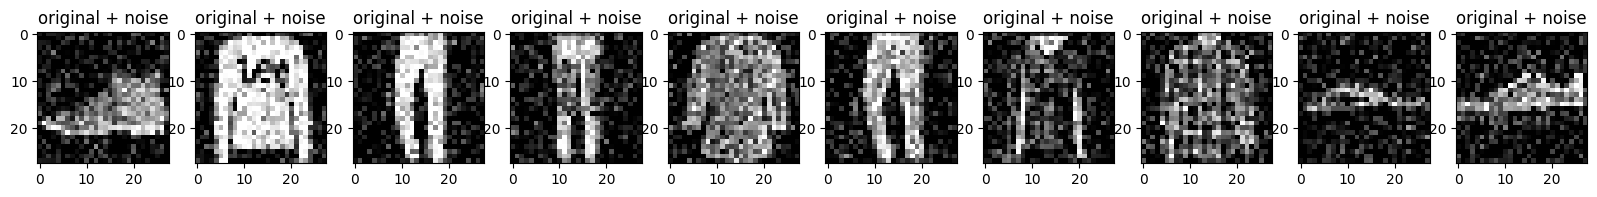

In [8]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

In [9]:
class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = tf.keras.Sequential([
          layers.Input(shape=(28, 28, 1)),
          layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
          layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

        self.decoder = tf.keras.Sequential([
          layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
          layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
          layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [10]:
autoencoder = Denoise()

In [11]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [12]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=30,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/30
1875/1875 [==============================] - 81s 41ms/step - loss: 0.0160 - val_loss: 0.0098
Epoch 2/30
1875/1875 [==============================] - 61s 32ms/step - loss: 0.0091 - val_loss: 0.0086
Epoch 3/30
1875/1875 [==============================] - 54s 29ms/step - loss: 0.0083 - val_loss: 0.0081
Epoch 4/30
1875/1875 [==============================] - 52s 28ms/step - loss: 0.0078 - val_loss: 0.0077
Epoch 5/30
1875/1875 [==============================] - 51s 27ms/step - loss: 0.0076 - val_loss: 0.0076
Epoch 6/30
1875/1875 [==============================] - 51s 27ms/step - loss: 0.0074 - val_loss: 0.0074
Epoch 7/30
1875/1875 [==============================] - 53s 28ms/step - loss: 0.0073 - val_loss: 0.0073
Epoch 8/30
1875/1875 [==============================] - 53s 28ms/step - loss: 0.0072 - val_loss: 0.0072
Epoch 9/30
1875/1875 [==============================] - 55s 29ms/step - loss: 0.0072 - val_loss: 0.0071
Epoch 10/30
1875/1875 [==============================] - 53s 28m

In [13]:
autoencoder.encoder.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
Total params: 1320 (5.16 KB)
Trainable params: 1320 (5.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
autoencoder.decoder.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTr  (None, 14, 14, 8)         584       
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 16)        1168      
 Transpose)                                                      
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         145       
                                                                 
Total params: 1897 (7.41 KB)
Trainable params: 1897 (7.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

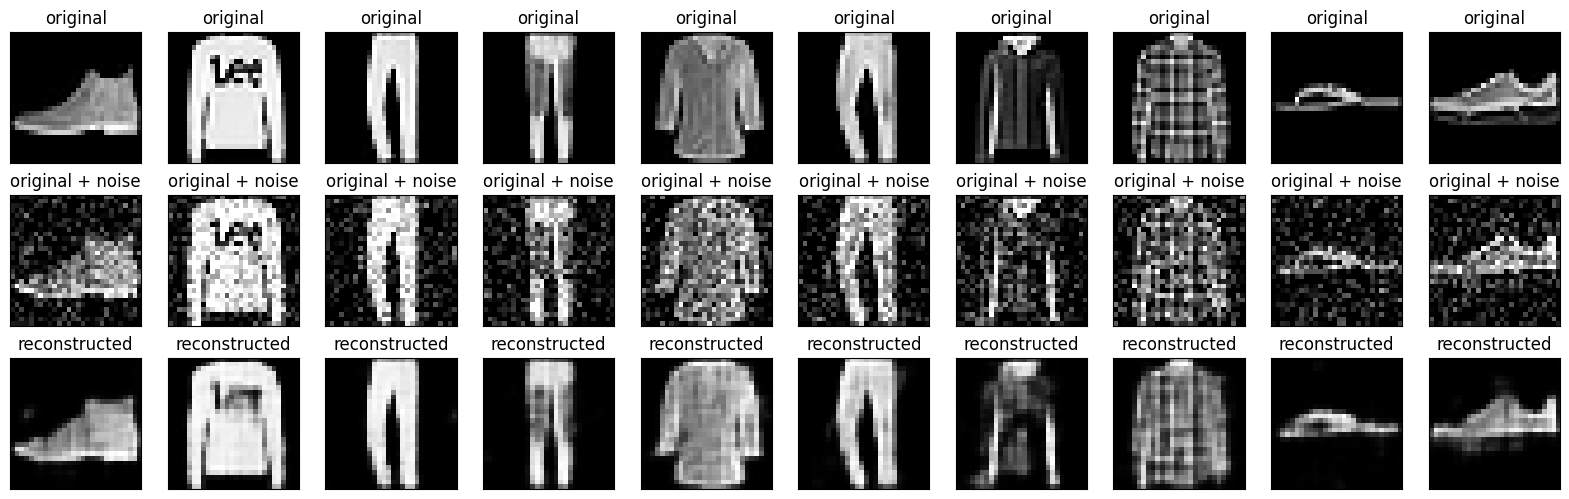

In [16]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(x_test[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display original + noise
    ax = plt.subplot(3, n, i + n + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(3, n, i + 2*n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

In [17]:
# Calculate the Mean Squared Error loss for the test dataset
test_loss = autoencoder.evaluate(x_test_noisy, x_test)
print(f"Mean Squared Error (MSE) Loss on Test Data: {test_loss:.4f}")

313/313 [==============================] - 3s 8ms/step - loss: 0.0066
Mean Squared Error (MSE) Loss on Test Data: 0.0066


Epoch 1/30
1875/1875 [==============================] - 52s 28ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 2/30
1875/1875 [==============================] - 52s 28ms/step - loss: 0.0066 - val_loss: 0.0067
Epoch 3/30
1875/1875 [==============================] - 54s 29ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 4/30
1875/1875 [==============================] - 52s 28ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 5/30
1875/1875 [==============================] - 54s 29ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 6/30
1875/1875 [==============================] - 53s 28ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 7/30
1875/1875 [==============================] - 54s 29ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 8/30
1875/1875 [==============================] - 51s 27ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 9/30
1875/1875 [==============================] - 52s 27ms/step - loss: 0.0065 - val_loss: 0.0066
Epoch 10/30
1875/1875 [==============================] - 52s 27m

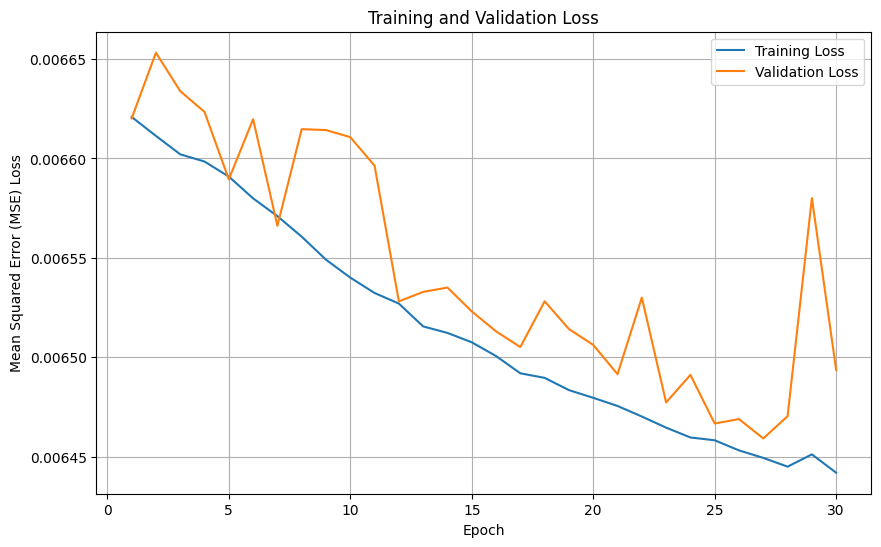

In [18]:
import matplotlib.pyplot as plt

# Train the autoencoder and collect loss history
history = autoencoder.fit(x_train_noisy, x_train,
                          epochs=30,
                          shuffle=True,
                          validation_data=(x_test_noisy, x_test))

# Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a plot of the loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE) Loss')
plt.legend()
plt.grid(True)
plt.show()